In [2]:
# Librerías
import pandas as pd
import os

# Ruta del archivo con los datos limpios
cleaned_data_filepath = "../data/processed/ai_stocks_historical_data_cleaned.parquet"

try:
    data_cleaned = pd.read_parquet(cleaned_data_filepath)
    print("\nDatos limpios usados en la exploración EDA")
    print(f"Rango de fechas de los datos cargados: {data_cleaned.index.min()} hasta {data_cleaned.index.max()}")
    print("\nPrimeras filas del DataFrame cargado:")
    print(data_cleaned.head())
except FileNotFoundError:
    print(f"\nERROR: Archivo no encontrado en la ruta especificada: {cleaned_data_filepath}")
    print("Verifica que el archivo .parquet fue copiado correctamente a la carpeta data/processed/ de este proyecto.")
except Exception as e:
    print(f"\nOcurrió un error al cargar el archivo: {e}")


Datos limpios usados en la exploración EDA
Rango de fechas de los datos cargados: 2015-04-20 00:00:00 hasta 2025-04-17 00:00:00

Primeras filas del DataFrame cargado:
Price           Close                                            High       \
Ticker           ARKQ BOTZ      GOOGL       MSFT      NVDA       ARKQ BOTZ   
Date                                                                         
2015-04-20  18.980328  NaN  27.096951  37.034481  0.532178  19.129559  NaN   
2015-04-21  19.008308  NaN  27.016832  36.801449  0.531456  19.026963  NaN   
2015-04-22  19.120234  NaN  27.328344  37.103531  0.537478  19.129561  NaN   
2015-04-23  19.259203  NaN  27.740372  37.405605  0.535310  19.260135  NaN   
2015-04-24  19.165934  NaN  28.546520  41.315315  0.530733  19.165934  NaN   

Price                                       ...       Open                  \
Ticker          GOOGL       MSFT      NVDA  ...       ARKQ BOTZ      GOOGL   
Date                                        ...    

## **Media Movil Simple**

In [ ]:
import pandas as pd
import ta.trend
import ta.volatility


tickers = data_cleaned.columns.get_level_values(1).unique() 

print("Calculando SMAs para cada ticker usando la librería 'ta'...")

# Iteraciones sobre cada ticker para calcular las SMAs
for ticker in tickers:
    # Seleccionamos la Serie 'Close' para el ticker actual
    close_series = data_cleaned[('Close', ticker)]

    # Calculamos la SMA de 20 períodos para esta Serie
    sma_20 = ta.trend.sma_indicator(close_series, window=20) 

    # Calculamos las SMAs opcionales de 50 y 100 períodos
    sma_50 = ta.trend.sma_indicator(close_series, window=50) 
    sma_100 = ta.trend.sma_indicator(close_series, window=100) 

    data_cleaned[('SMA_20', ticker)] = sma_20
    data_cleaned[('SMA_50', ticker)] = sma_50
    data_cleaned[('SMA_100', ticker)] = sma_100

print("SMAs añadidas a DataFrame.")

print("\nDataFrame con SMAs añadidas usando 'ta':")
print(data_cleaned.head())

print("\nÚltimas filas:")
print(data_cleaned.tail())

print("\nInformación del DataFrame:")
data_cleaned.info()

print("\nColumnas del DataFrame para verificar los nombres de las SMAs:")
print(data_cleaned.columns)

Calculando SMAs para cada ticker usando la librería 'ta'...
SMAs añadidas a DataFrame.

DataFrame con SMAs añadidas usando 'ta':
Price           Close                                            High       \
Ticker           ARKQ BOTZ      GOOGL       MSFT      NVDA       ARKQ BOTZ   
Date                                                                         
2015-04-20  18.980328  NaN  27.096951  37.034481  0.532178  19.129559  NaN   
2015-04-21  19.008308  NaN  27.016832  36.801449  0.531456  19.026963  NaN   
2015-04-22  19.120234  NaN  27.328344  37.103531  0.537478  19.129561  NaN   
2015-04-23  19.259203  NaN  27.740372  37.405605  0.535310  19.260135  NaN   
2015-04-24  19.165934  NaN  28.546520  41.315315  0.530733  19.165934  NaN   

Price                                       ... SMA_100 SMA_20 SMA_50 SMA_100  \
Ticker          GOOGL       MSFT      NVDA  ...    BOTZ  GOOGL  GOOGL   GOOGL   
Date                                        ...                                 
201

## **Visualizar Precio de Cierre y SMAs por Ticker**

Generando gráfico de Precio de Cierre y Medias Móviles para NVDA...


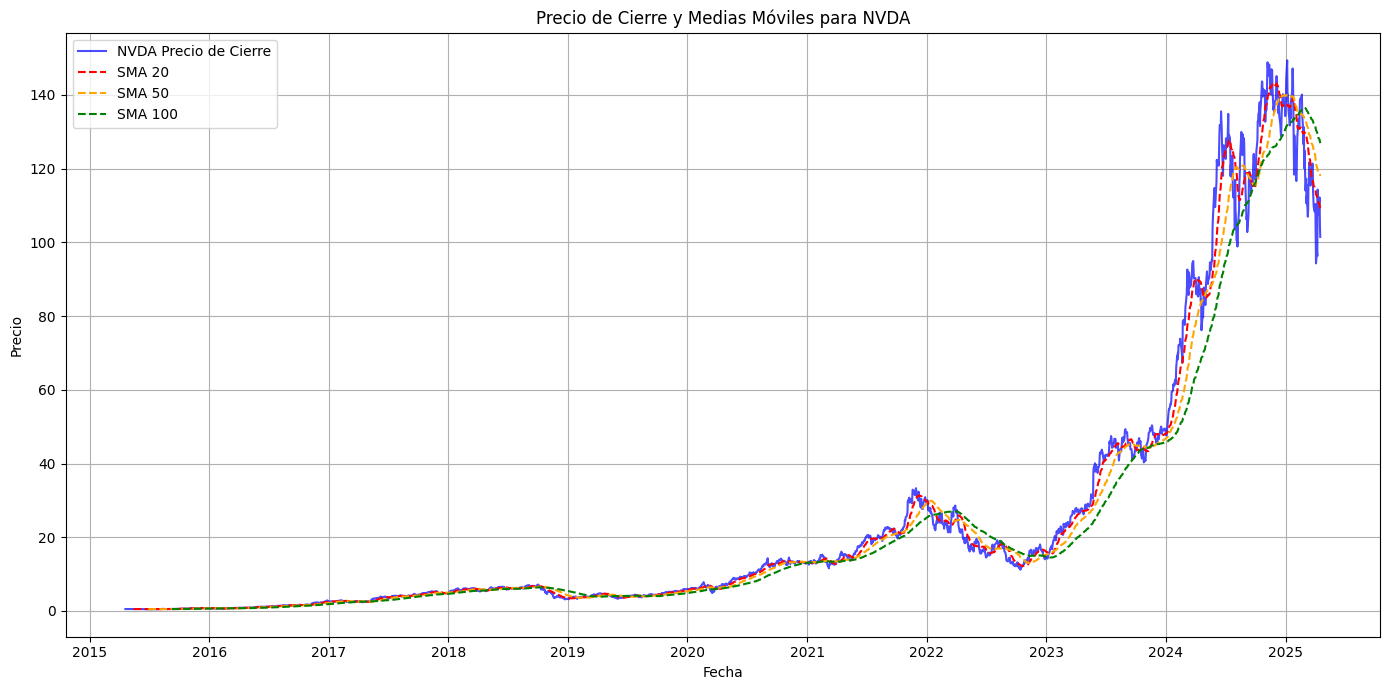

In [ ]:
import matplotlib.pyplot as plt 

# Averiguaremos puntualmente con NVDA
ticker_to_plot = 'NVDA' #('MSFT', 'GOOGL', 'BOTZ', 'ARKQ', etc.)

print(f"Generando gráfico de Precio de Cierre y Medias Móviles para {ticker_to_plot}...")

# Gráfico
plt.figure(figsize=(14, 7)) 

price_data = data_cleaned[('Close', ticker_to_plot)]
plt.plot(price_data.index, price_data, label=f'{ticker_to_plot} Precio de Cierre', color='blue', alpha=0.7)

try:
    sma_20_data = data_cleaned[('SMA_20', ticker_to_plot)]
    sma_50_data = data_cleaned[('SMA_50', ticker_to_plot)]
    sma_100_data = data_cleaned[('SMA_100', ticker_to_plot)]

    plt.plot(sma_20_data.dropna().index, sma_20_data.dropna(), label='SMA 20', color='red', linestyle='--')
    plt.plot(sma_50_data.dropna().index, sma_50_data.dropna(), label='SMA 50', color='orange', linestyle='--')
    plt.plot(sma_100_data.dropna().index, sma_100_data.dropna(), label='SMA 100', color='green', linestyle='--')

except KeyError as e:
    print(f"Error al acceder a las columnas de SMA para {ticker_to_plot}: {e}.")
    print("Verifica que las columnas SMA existan y estén nombradas correctamente en data_cleaned.columns.")
    print("Columnas disponibles (primeros 100):", data_cleaned.columns[:100]) 


plt.title(f'Precio de Cierre y Medias Móviles para {ticker_to_plot}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show()

## **Cálculo del RSI**

In [ ]:
import ta.momentum # Importamos el submódulo momentum

print("\nCalculando RSI para cada ticker usando la librería 'ta'...")

for ticker in tickers: # Reutilizamos la lista 'tickers' de la celda anterior

    close_series = data_cleaned[('Close', ticker)]

    # Calculamos el RSI para esta Serie
    rsi_14 = ta.momentum.rsi(close_series, window=14)

    data_cleaned[('RSI_14', ticker)] = rsi_14

print("RSI añadido a DataFrame.")


Calculando RSI para cada ticker usando la librería 'ta'...
RSI añadido a DataFrame.


## **Precio y RSI**

Generando gráfico de Precio, SMAs y RSI para NVDA...


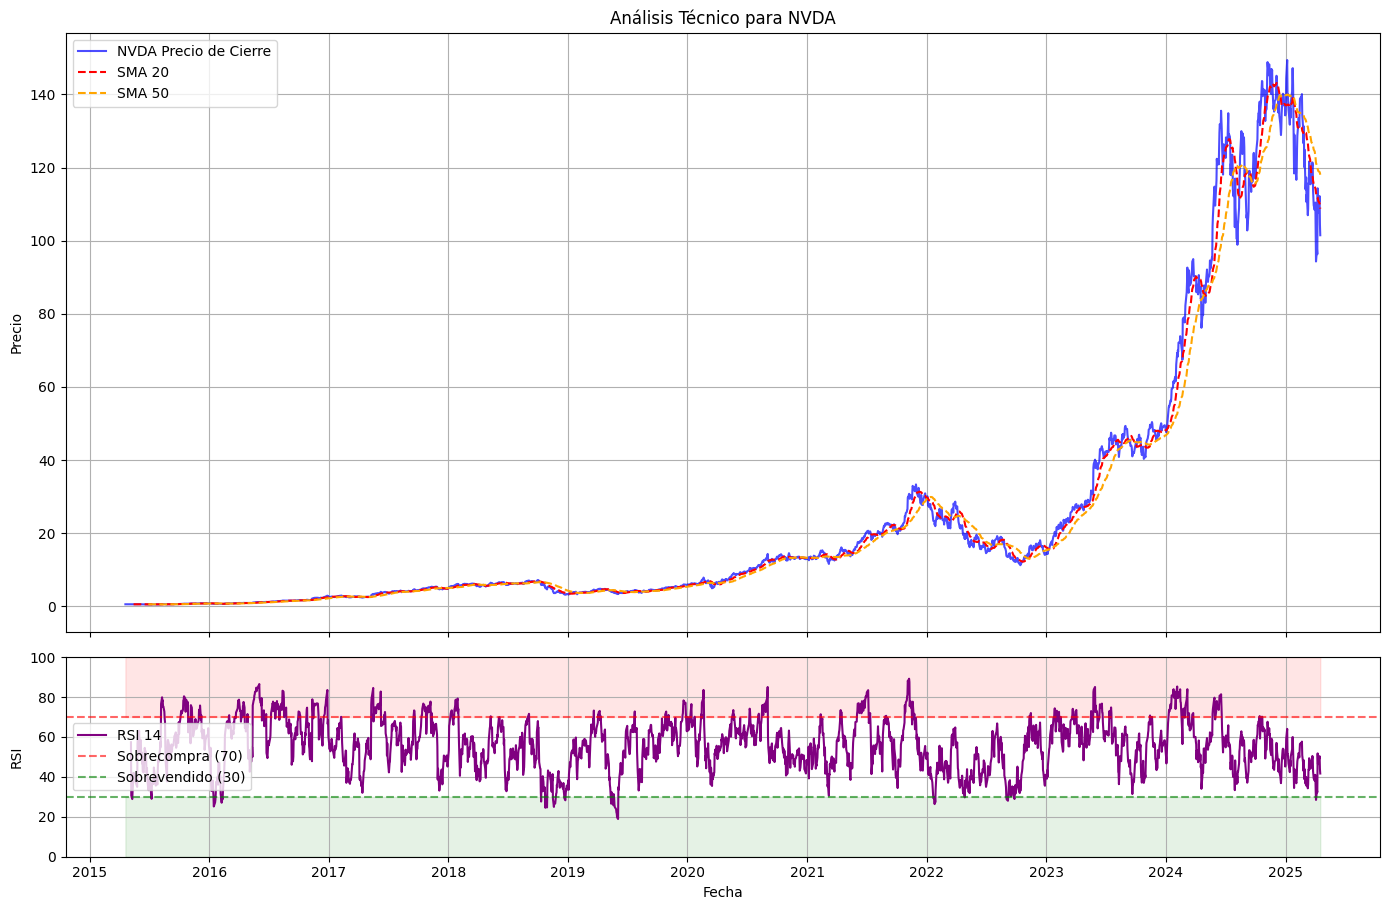

In [ ]:
import matplotlib.pyplot as plt 

ticker_to_plot = 'NVDA' # Trabajaremos con NVIDIA

print(f"Generando gráfico de Precio, SMAs y RSI para {ticker_to_plot}...")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1 = axes[0] # El primer subplot (arriba)
price_data = data_cleaned[('Close', ticker_to_plot)]
ax1.plot(price_data.index, price_data, label=f'{ticker_to_plot} Precio de Cierre', color='blue', alpha=0.7)

# Opcional: Graficar SMAs si existen
try:
    sma_20_data = data_cleaned[('SMA_20', ticker_to_plot)]
    sma_50_data = data_cleaned[('SMA_50', ticker_to_plot)]
    ax1.plot(sma_20_data.dropna().index, sma_20_data.dropna(), label='SMA 20', color='red', linestyle='--')
    ax1.plot(sma_50_data.dropna().index, sma_50_data.dropna(), label='SMA 50', color='orange', linestyle='--')

except KeyError:
    print(f"Columnas SMA no encontradas para {ticker_to_plot}. Graficando solo precio.")

ax1.set_ylabel('Precio')
ax1.set_title(f'Análisis Técnico para {ticker_to_plot}') 
ax1.legend()
ax1.grid(True)

ax2 = axes[1] # El segundo subplot (abajo)
try:
    rsi_data = data_cleaned[('RSI_14', ticker_to_plot)]
    ax2.plot(rsi_data.index, rsi_data, label='RSI 14', color='purple')

    ax2.axhline(70, color='red', linestyle='--', alpha=0.6, label='Sobrecompra (70)')
    ax2.axhline(30, color='green', linestyle='--', alpha=0.6, label='Sobrevendido (30)')
    ax2.set_ylim(0, 100) 
    ax2.fill_between(rsi_data.index, 70, 100, color='red', alpha=0.1) 
    ax2.fill_between(rsi_data.index, 0, 30, color='green', alpha=0.1) 
except KeyError:
    print(f"Columna RSI no encontrada para {ticker_to_plot}. No se grafica RSI.")


ax2.set_ylabel('RSI')
ax2.set_xlabel('Fecha') 
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

## **MACD (Moving Average Convergence Divergence)**


Calculando MACD para cada ticker usando la librería 'ta'...
Componentes del MACD añadidos al DataFrame.

Generando gráficos de Precio de Cierre, SMAs y MACD por ticker...


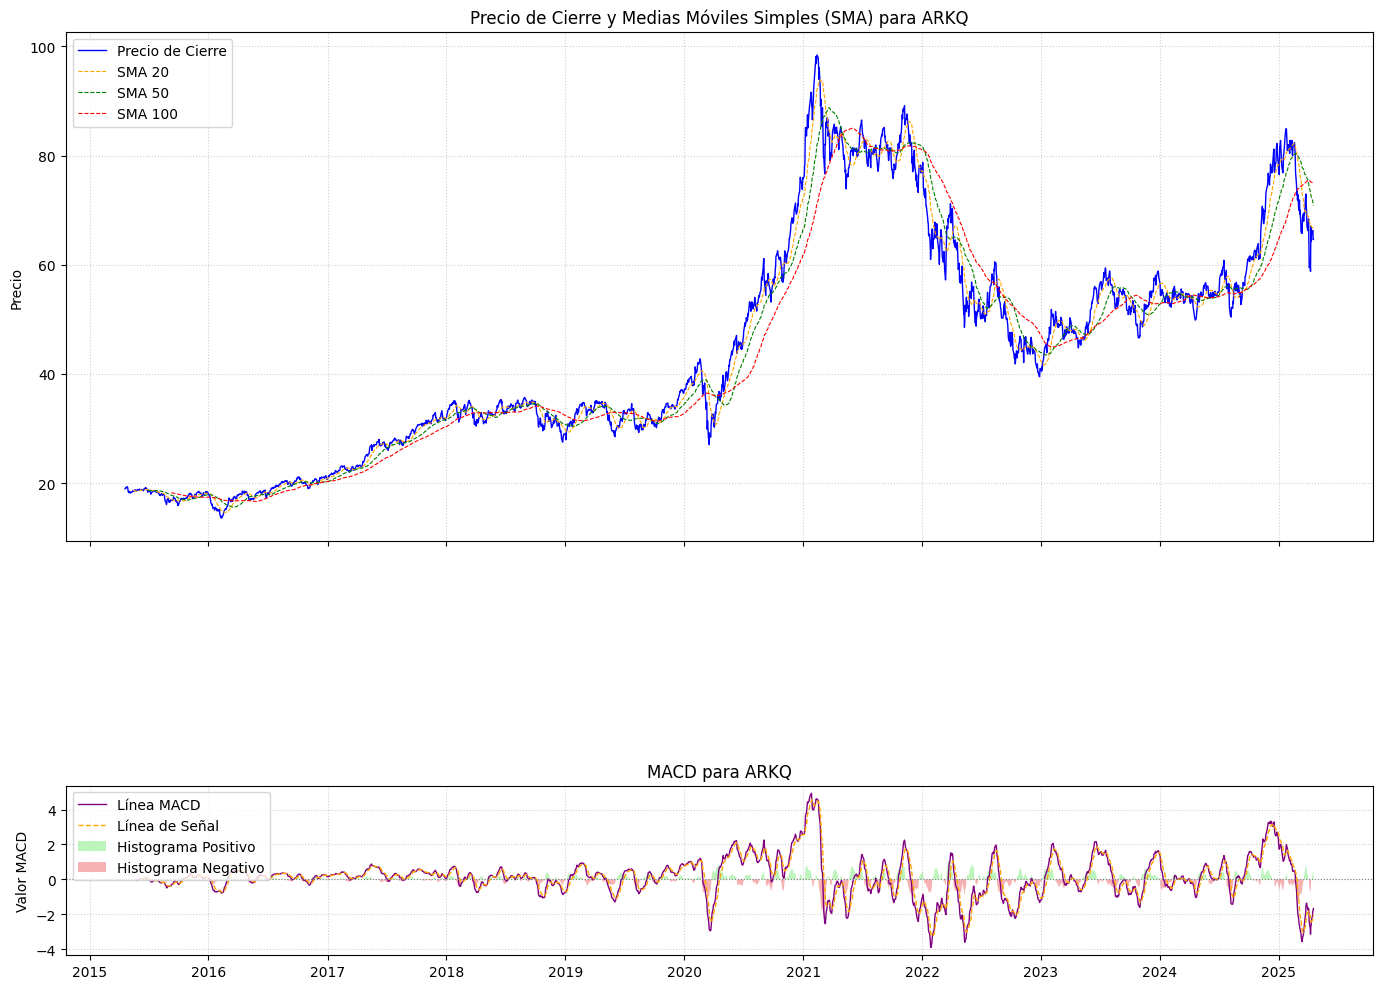

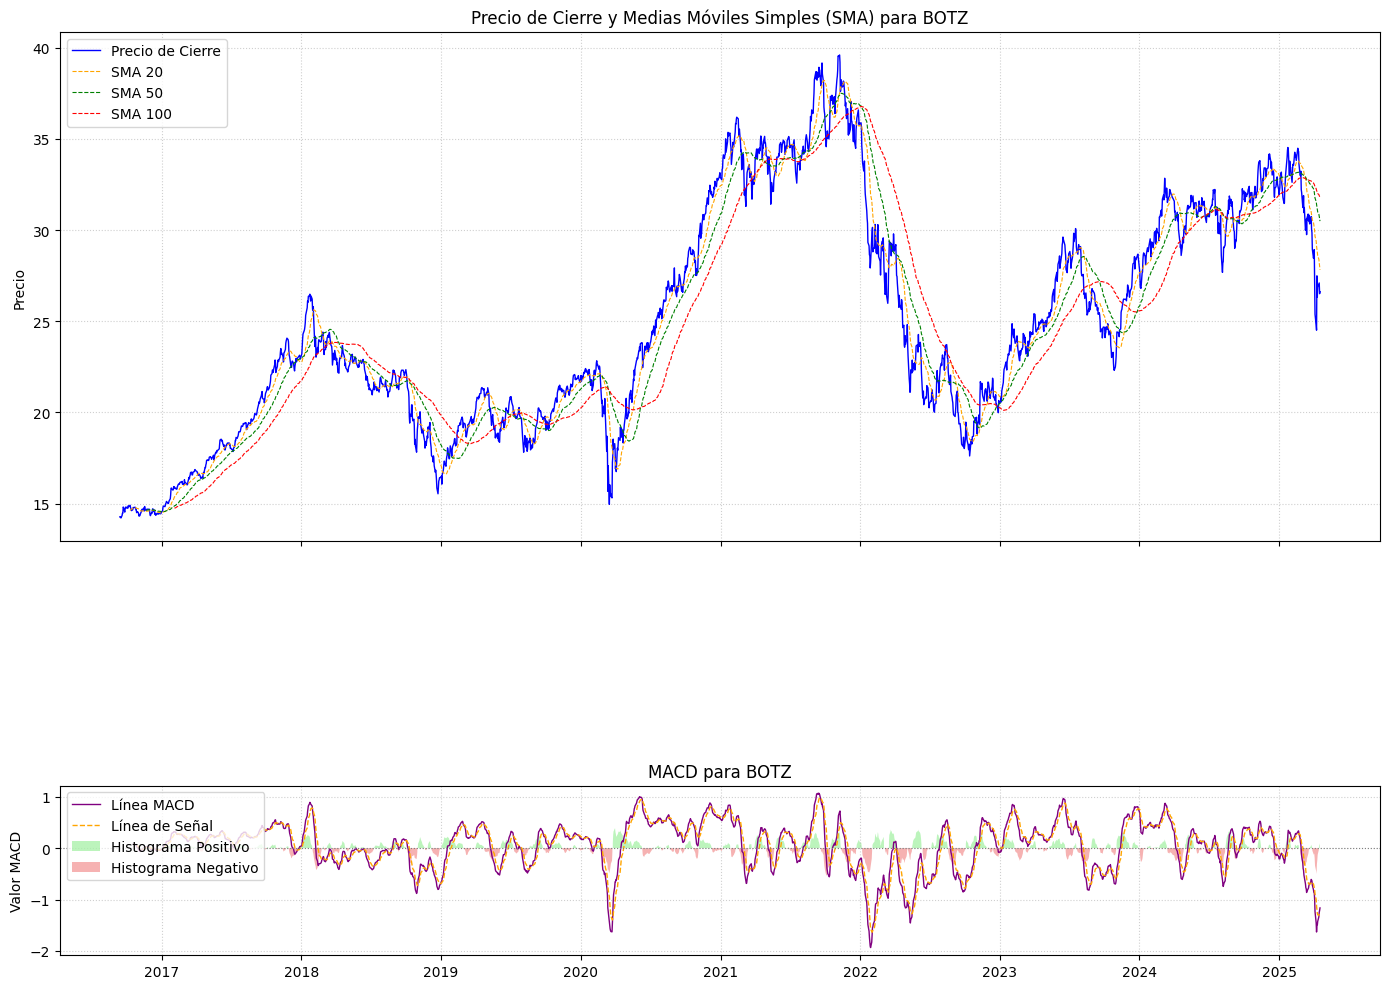

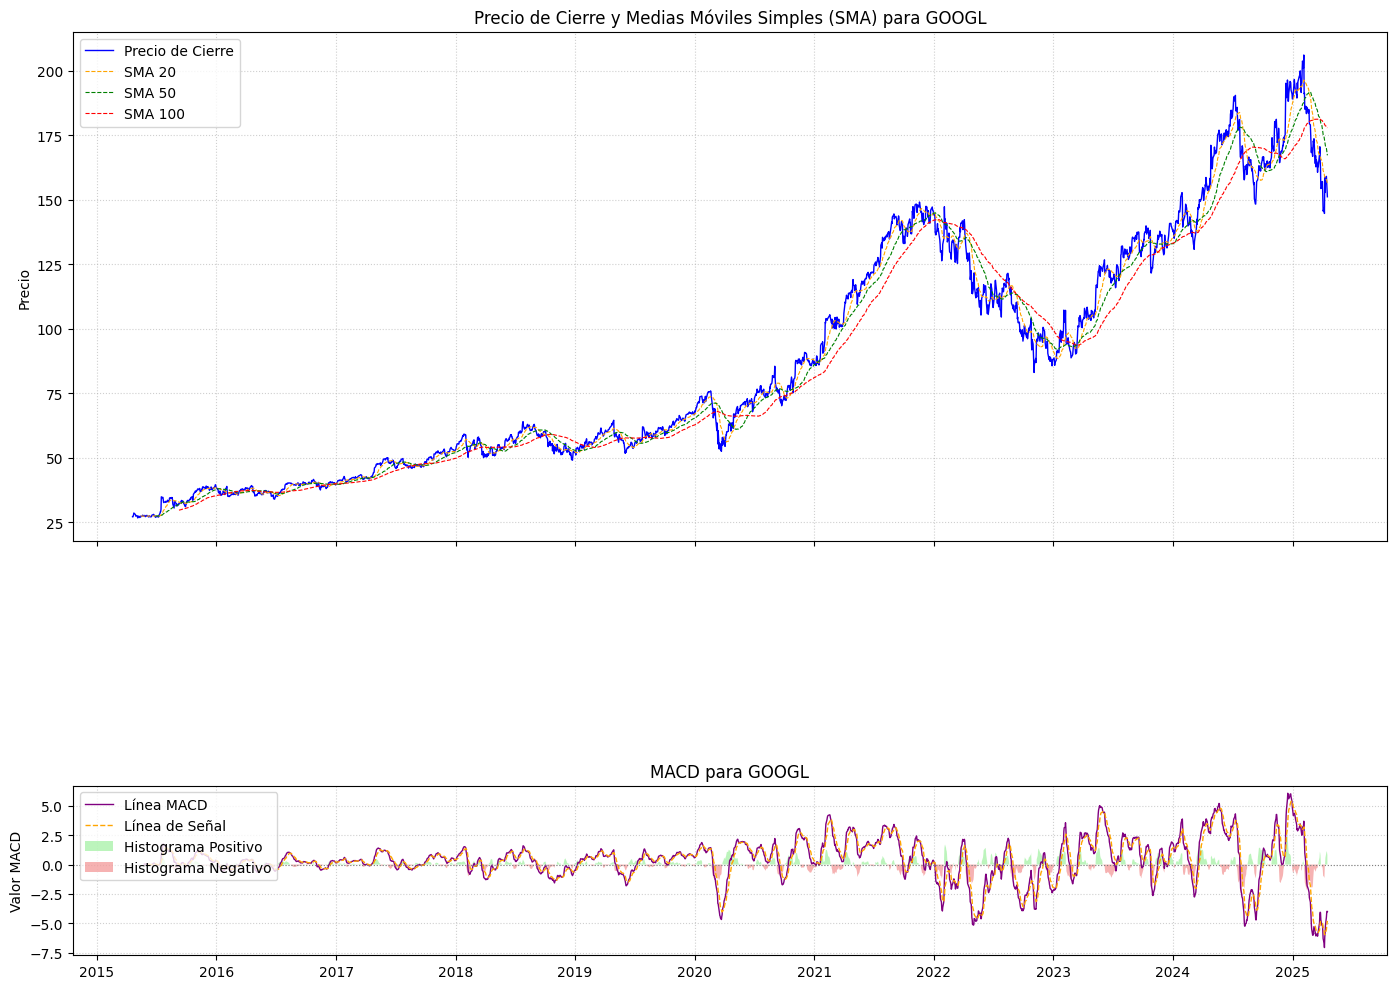

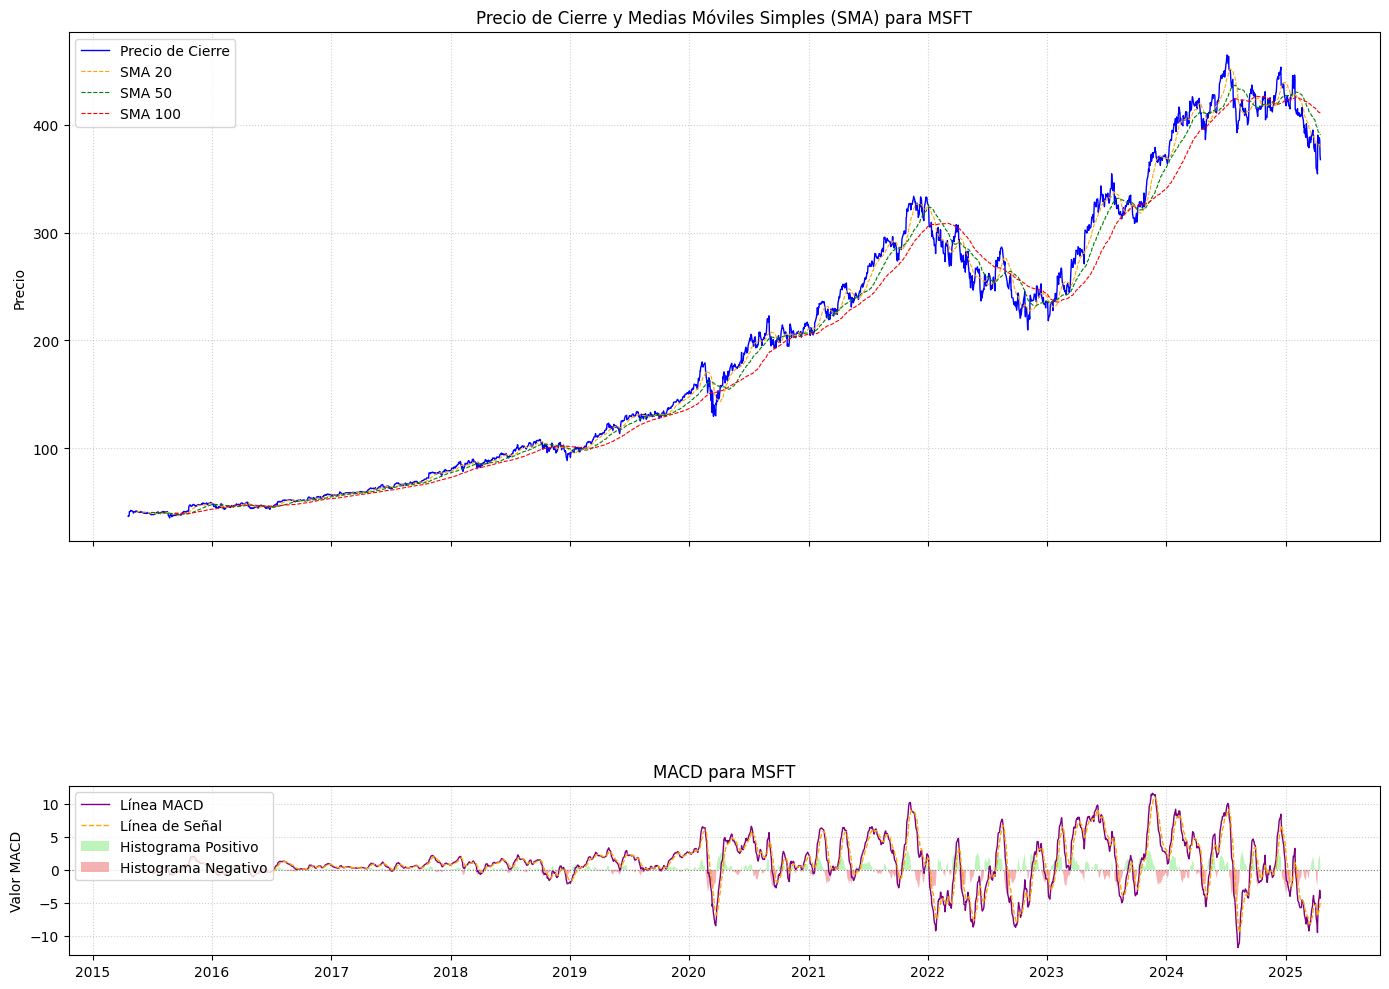

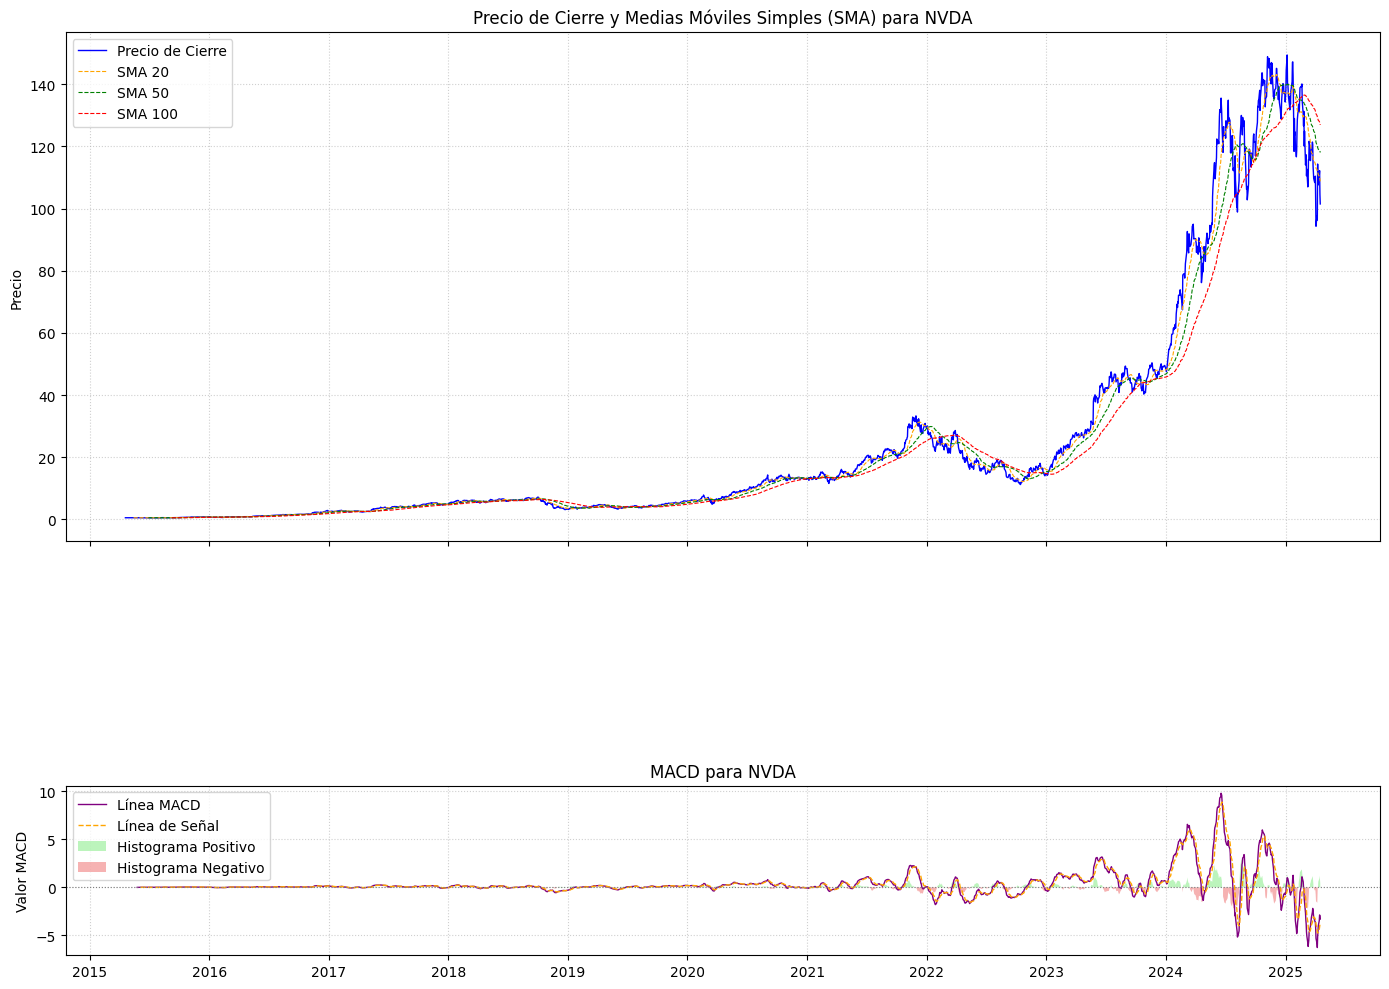


Visualización de MACD completada para todos los tickers.


In [ ]:
import pandas as pd
import ta.trend 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec # Para organizar los subplots

if not isinstance(data_cleaned.index, pd.DatetimeIndex):
    data_cleaned.index = pd.to_datetime(data_cleaned.index)
    print("Índice convertido a DatetimeIndex.")


# Calculamos MACD para cada ticker ---
print("\nCalculando MACD para cada ticker usando la librería 'ta'...")

tickers = data_cleaned.columns.get_level_values(1).unique()

for ticker in tickers:
    close_series = data_cleaned[('Close', ticker)]

    macd_line = ta.trend.macd(close_series, window_fast=12, window_slow=26)
    macd_signal = ta.trend.macd_signal(close_series, window_fast=12, window_slow=26, window_sign=9)
    macd_diff = ta.trend.macd_diff(close_series, window_fast=12, window_slow=26, window_sign=9) 

    data_cleaned[('MACD_Line', ticker)] = macd_line
    data_cleaned[('MACD_Signal', ticker)] = macd_signal
    data_cleaned[('MACD_Hist', ticker)] = macd_diff 

print("Componentes del MACD añadidos al DataFrame.")

# Visualizamos el precio de cierre
print("\nGenerando gráficos de Precio de Cierre, SMAs y MACD por ticker...")

for ticker in tickers:
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1])

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(data_cleaned.index, data_cleaned[('Close', ticker)], label='Precio de Cierre', color='blue', linewidth=1)
    if ('SMA_20', ticker) in data_cleaned.columns:
        ax0.plot(data_cleaned.index, data_cleaned[('SMA_20', ticker)], label='SMA 20', color='orange', linestyle='--', linewidth=0.8)
    if ('SMA_50', ticker) in data_cleaned.columns:
        ax0.plot(data_cleaned.index, data_cleaned[('SMA_50', ticker)], label='SMA 50', color='green', linestyle='--', linewidth=0.8)
    if ('SMA_100', ticker) in data_cleaned.columns:
        ax0.plot(data_cleaned.index, data_cleaned[('SMA_100', ticker)], label='SMA 100', color='red', linestyle='--', linewidth=0.8)
    
    ax0.set_title(f'Precio de Cierre y Medias Móviles Simples (SMA) para {ticker}')
    ax0.set_ylabel('Precio')
    ax0.legend(loc='upper left')
    ax0.grid(True, linestyle=':', alpha=0.6)
    # Ocultamos las etiquetas X para evitar que se superpongan con el subplot inferior
    plt.setp(ax0.get_xticklabels(), visible=False)

    ax2 = fig.add_subplot(gs[2, 0], sharex=ax0)
    ax2.plot(data_cleaned.index, data_cleaned[('MACD_Line', ticker)], label='Línea MACD', color='purple', linewidth=1)
    ax2.plot(data_cleaned.index, data_cleaned[('MACD_Signal', ticker)], label='Línea de Señal', color='orange', linestyle='--', linewidth=1)
    
    hist_data = data_cleaned[('MACD_Hist', ticker)].dropna()
    hist_index = hist_data.index
    ax2.fill_between(hist_index, hist_data, 0,
                     where=(hist_data > 0), facecolor='lightgreen', alpha=0.6, label='Histograma Positivo')
    ax2.fill_between(hist_index, hist_data, 0,
                     where=(hist_data < 0), facecolor='lightcoral', alpha=0.6, label='Histograma Negativo')
    
    ax2.axhline(0, color='gray', linestyle=':', linewidth=0.8) 
    ax2.set_title(f'MACD para {ticker}')
    ax2.set_ylabel('Valor MACD')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout() 
    plt.show()

print("\nVisualización de MACD completada para todos los tickers.")


Calculando Bandas de Bollinger (BB) para cada ticker usando la librería 'ta'...
Bandas de Bollinger añadidas al DataFrame.

Generando gráficos de Precio de Cierre con Bandas de Bollinger, y MACD por ticker...


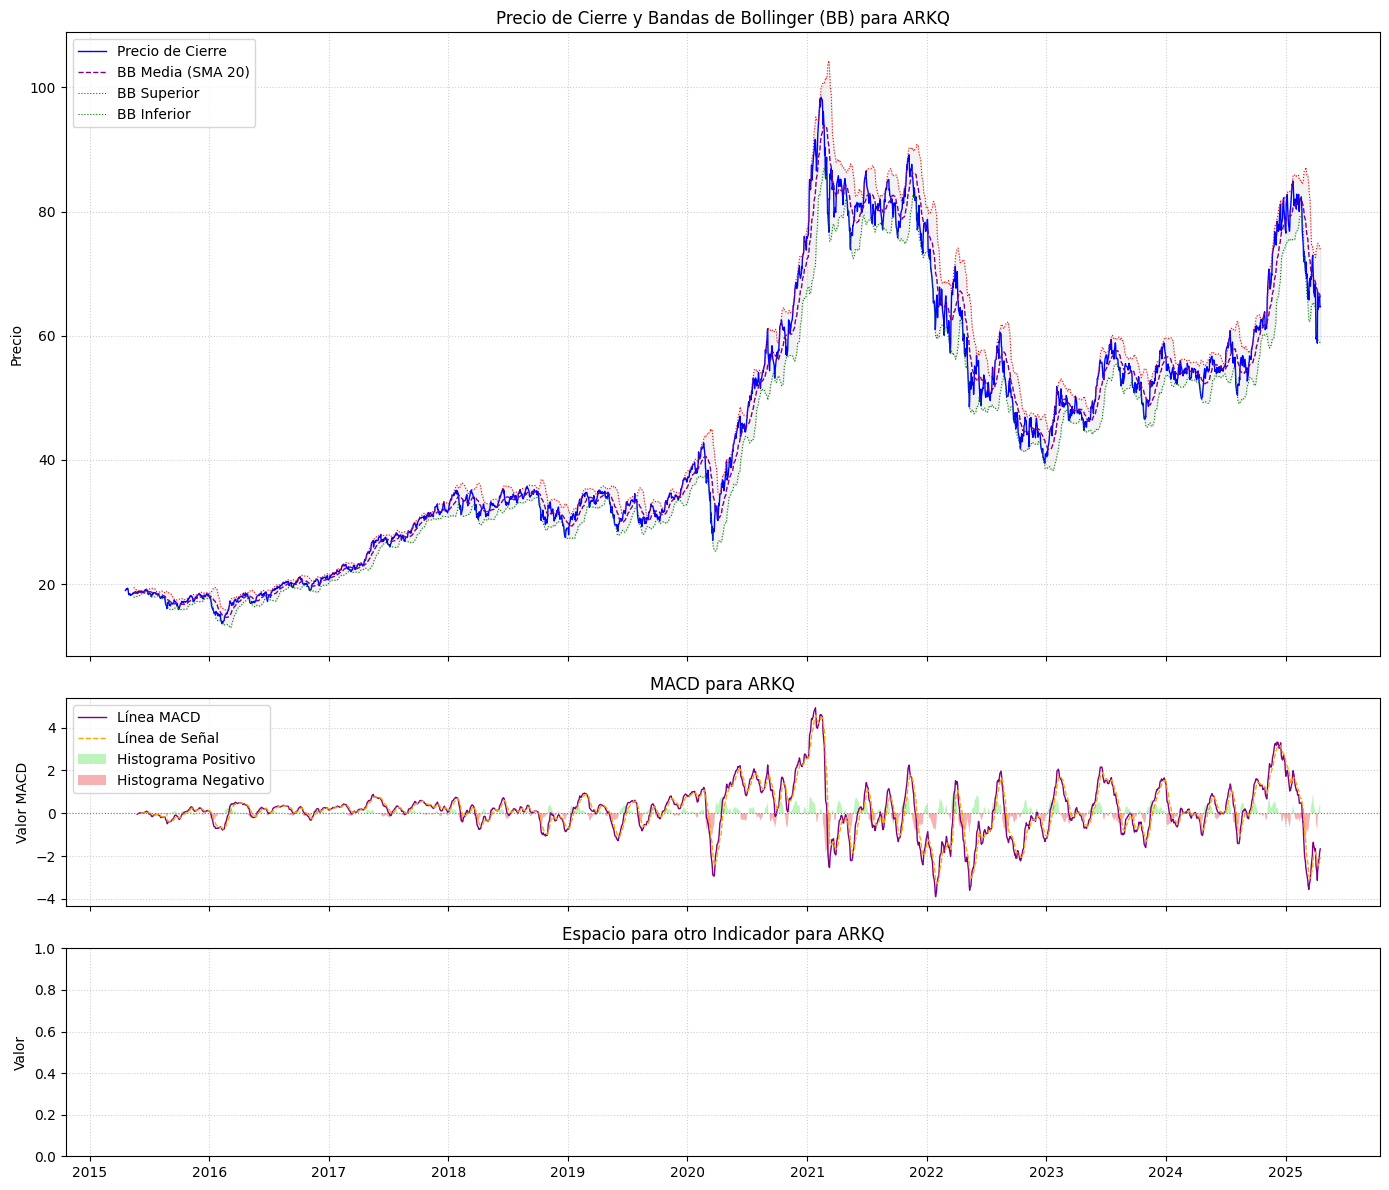

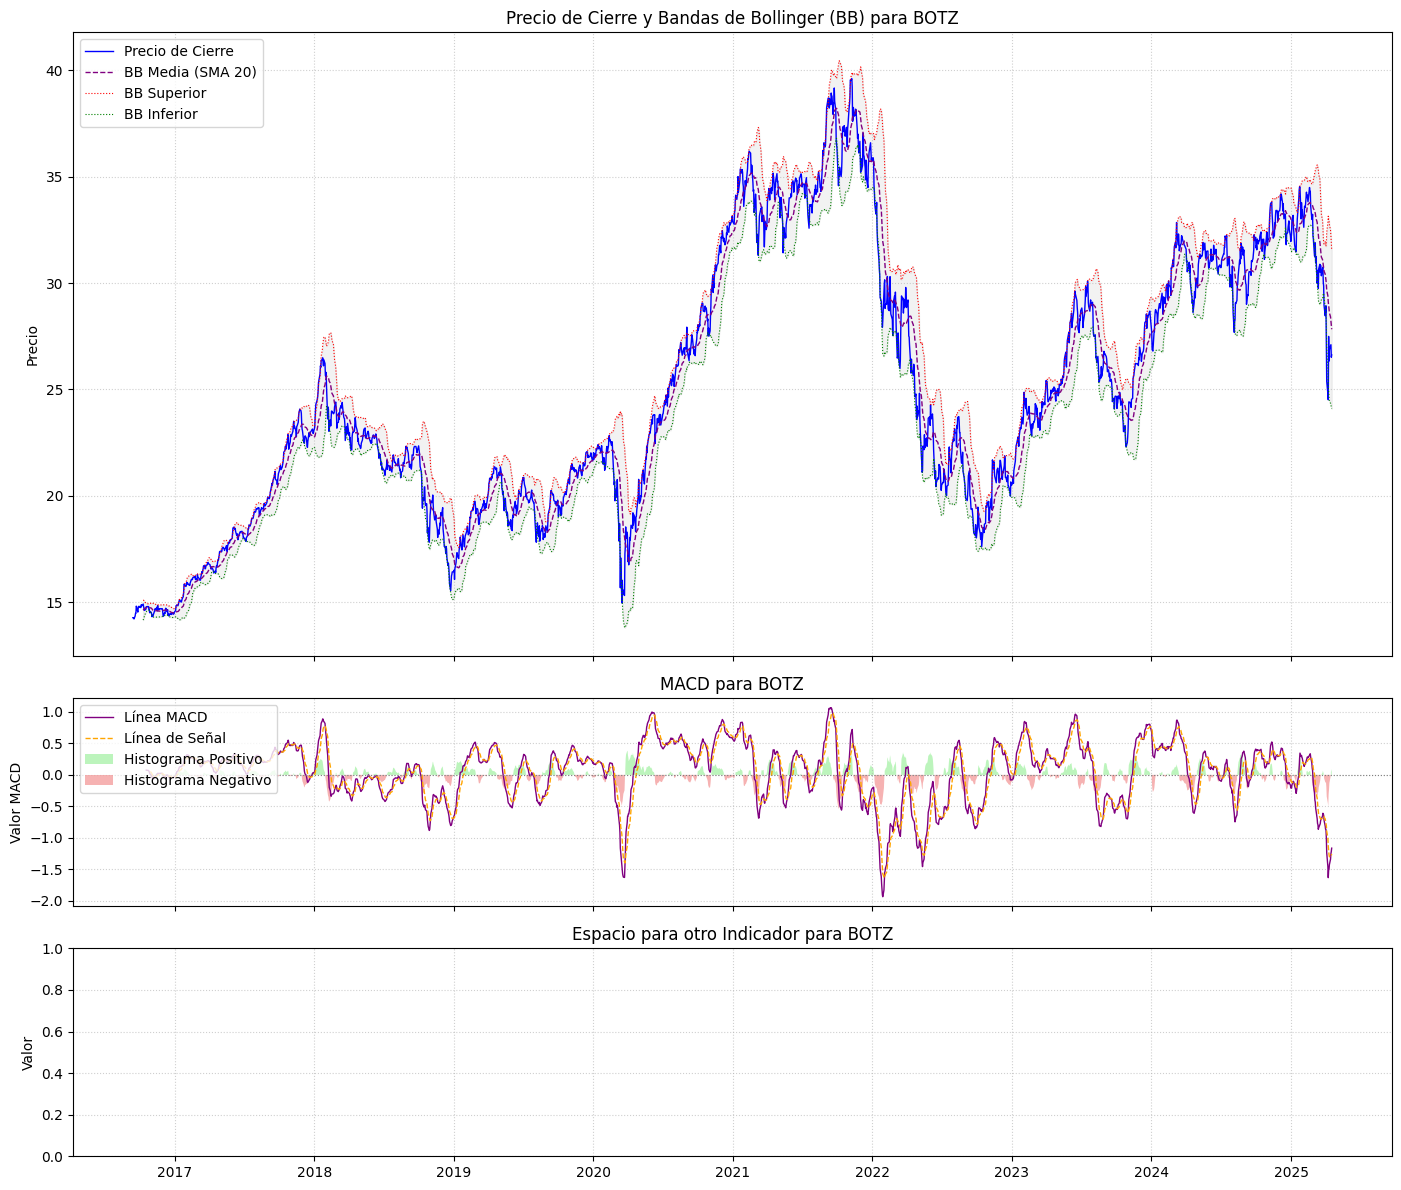

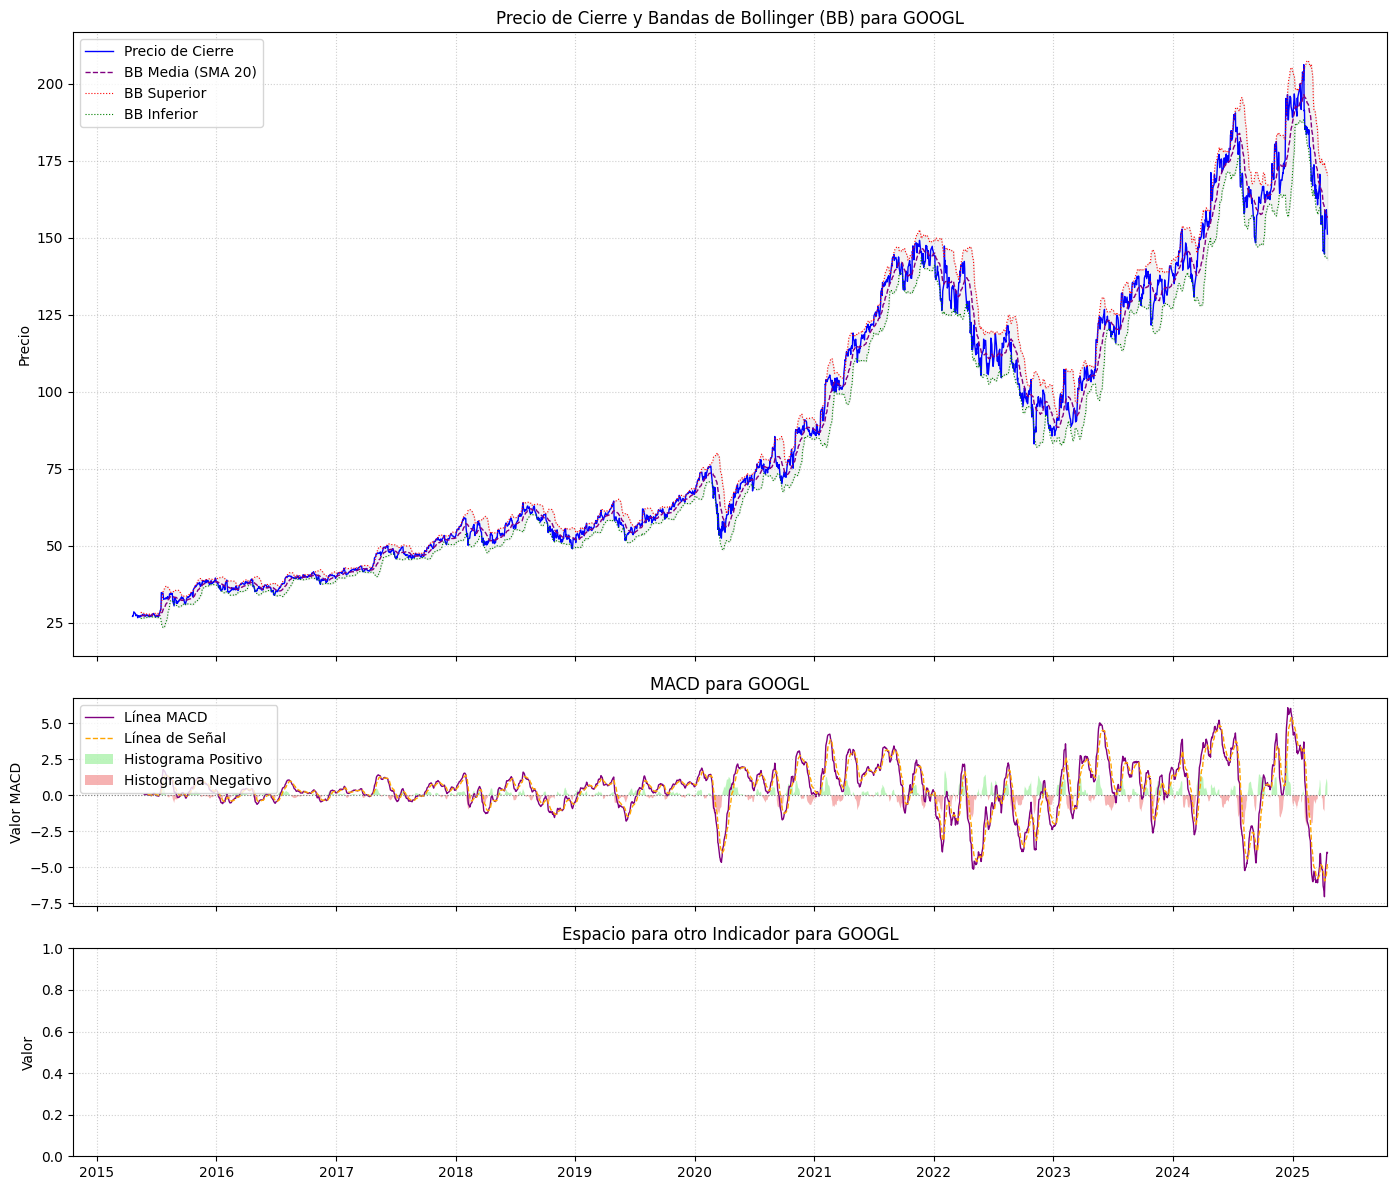

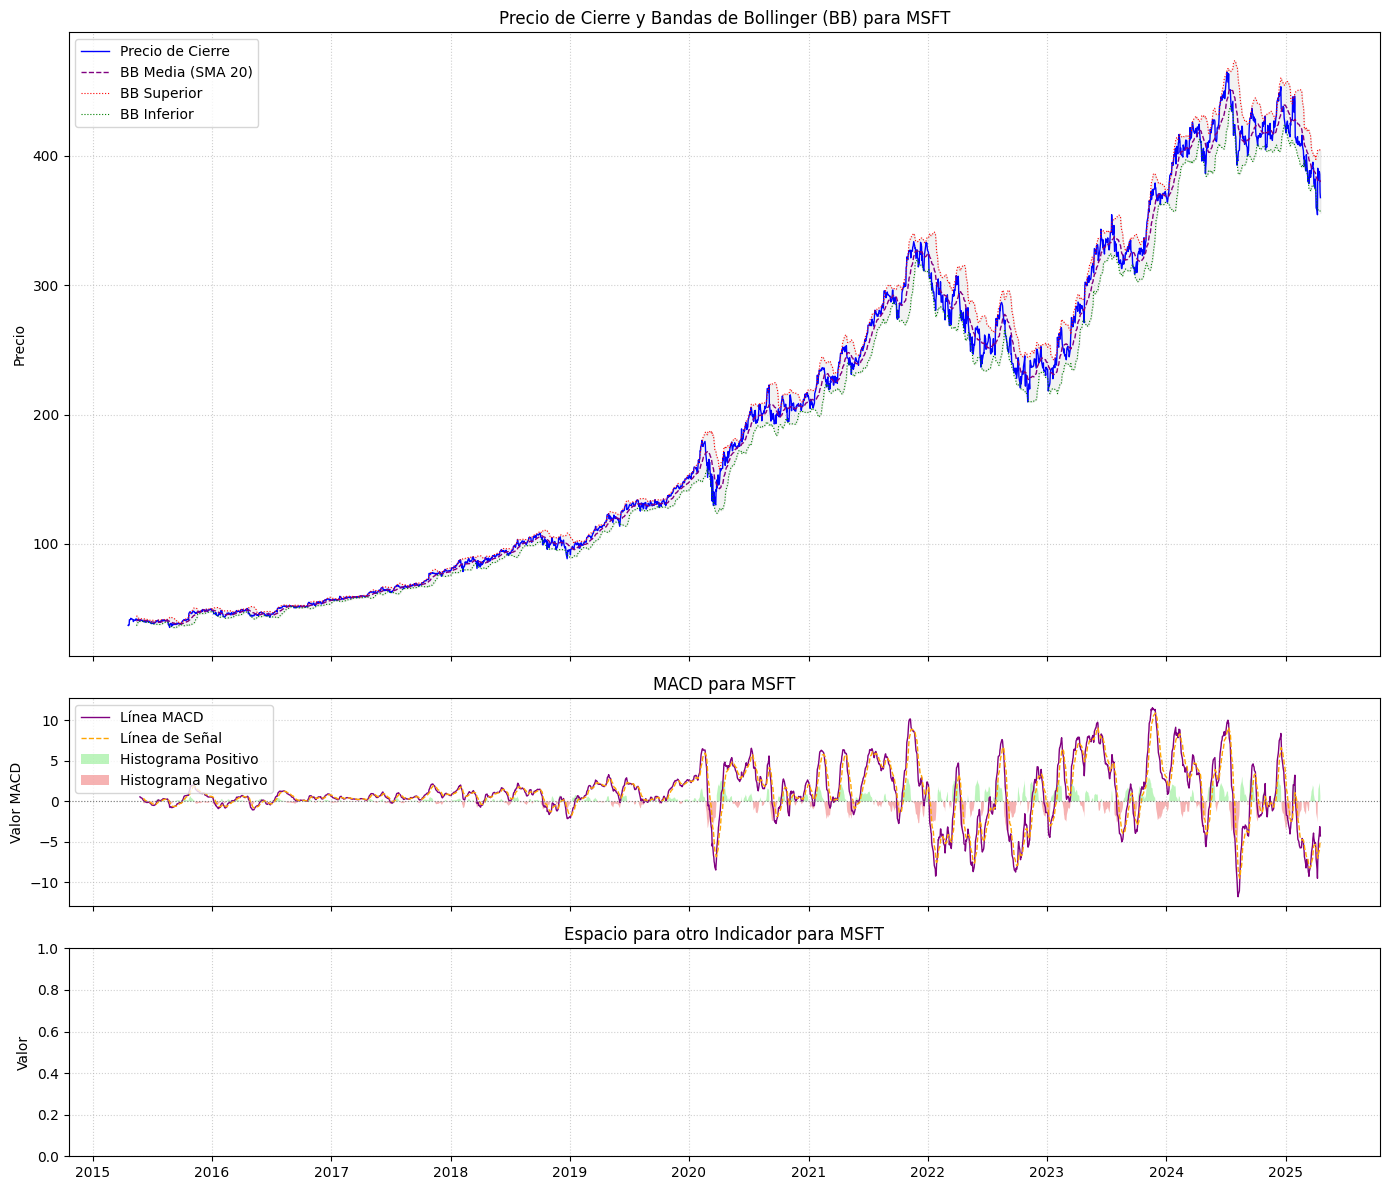

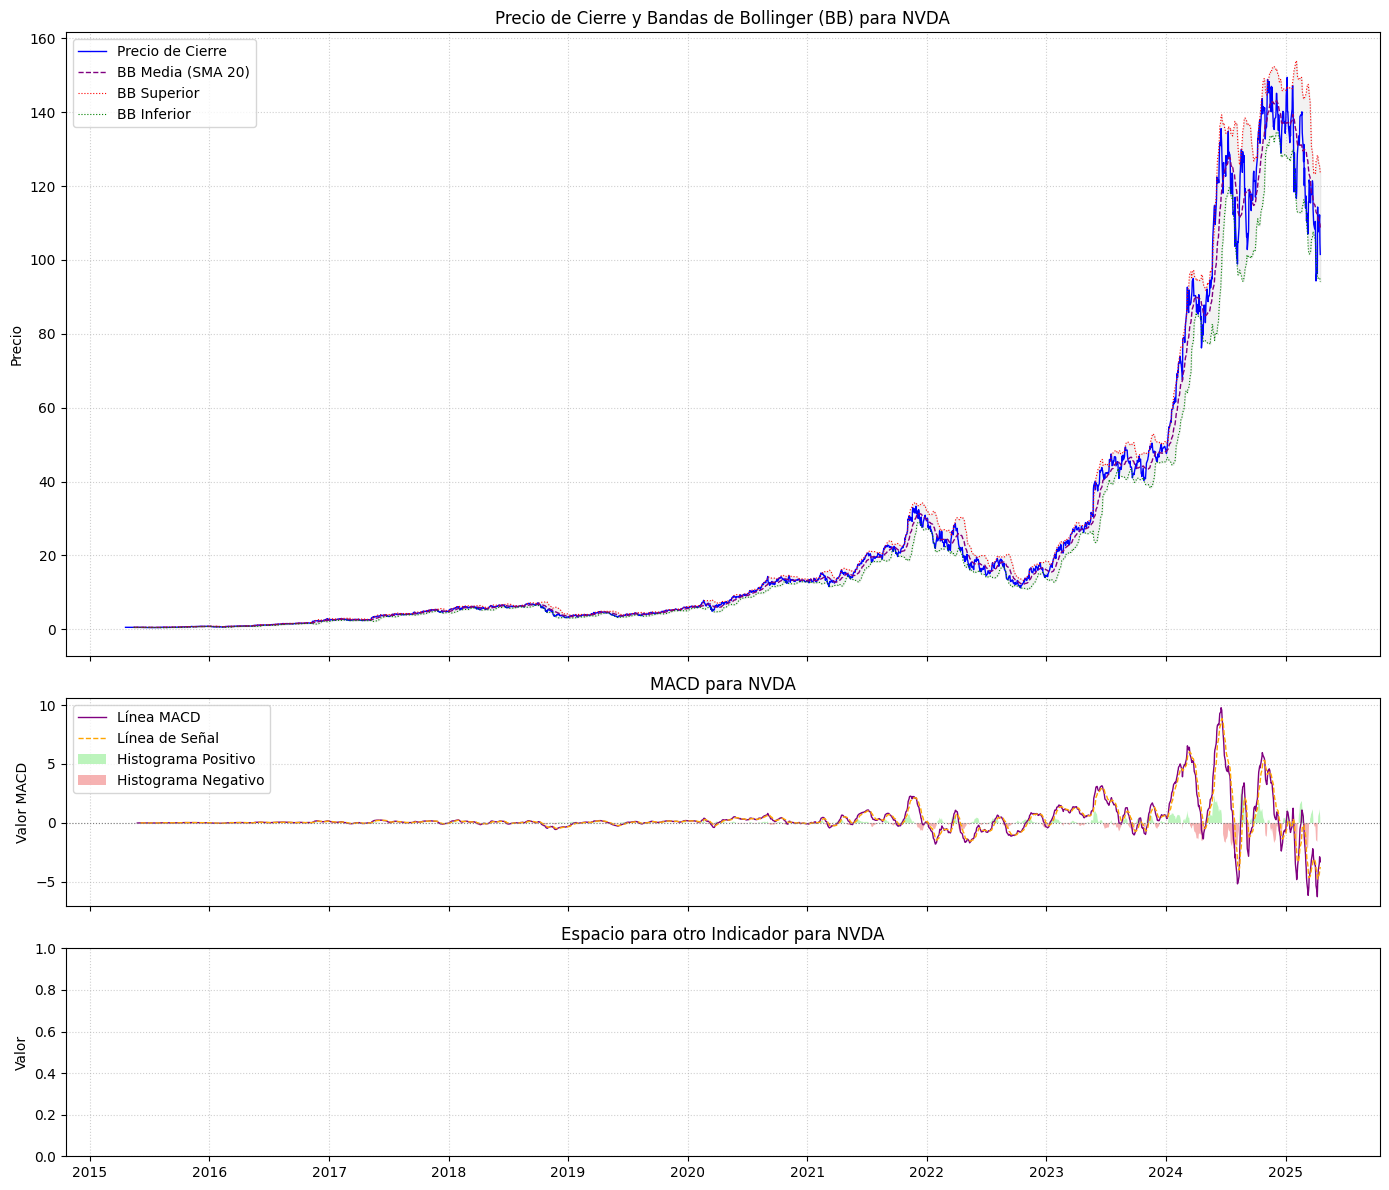


Visualización de Bandas de Bollinger y MACD completada para todos los tickers.


In [ ]:
import pandas as pd
import ta.volatility 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

if not isinstance(data_cleaned.index, pd.DatetimeIndex):
    data_cleaned.index = pd.to_datetime(data_cleaned.index)
    print("Índice convertido a DatetimeIndex.")


print("\nCalculando Bandas de Bollinger (BB) para cada ticker usando la librería 'ta'...")

# Obtenemos la lista de tickers
tickers = data_cleaned.columns.get_level_values(1).unique()

for ticker in tickers:
    close_series = data_cleaned[('Close', ticker)]

    # Calcula los componentes de las Bandas de Bollinger (ventanas estándar: 20 períodos, 2 desviaciones)
    bb_hband = ta.volatility.bollinger_hband(close_series, window=20, window_dev=2) 
    bb_lband = ta.volatility.bollinger_lband(close_series, window=20, window_dev=2) 
    bb_mavg = ta.volatility.bollinger_mavg(close_series, window=20) 

    # Añade los componentes de BB como nuevas columnas al DataFrame
    data_cleaned[('BB_HBand', ticker)] = bb_hband
    data_cleaned[('BB_LBand', ticker)] = bb_lband
    data_cleaned[('BB_MAvg', ticker)] = bb_mavg

print("Bandas de Bollinger añadidas al DataFrame.")

# Visualizar Precio de Cierre, Bandas de Bollinger y MACD por Ticker 
print("\nGenerando gráficos de Precio de Cierre con Bandas de Bollinger, y MACD por ticker...")

for ticker in tickers:
    fig = plt.figure(figsize=(14, 12)) 
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1]) 

    # Precio de Cierre y Bandas de Bollinger ---
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(data_cleaned.index, data_cleaned[('Close', ticker)], label='Precio de Cierre', color='blue', linewidth=1)
    ax0.plot(data_cleaned.index, data_cleaned[('BB_MAvg', ticker)], label='BB Media (SMA 20)', color='purple', linestyle='--', linewidth=1)
    ax0.plot(data_cleaned.index, data_cleaned[('BB_HBand', ticker)], label='BB Superior', color='red', linestyle=':', linewidth=0.8)
    ax0.plot(data_cleaned.index, data_cleaned[('BB_LBand', ticker)], label='BB Inferior', color='green', linestyle=':', linewidth=0.8)
    
    ax0.fill_between(data_cleaned.index, data_cleaned[('BB_LBand', ticker)], data_cleaned[('BB_HBand', ticker)], color='gray', alpha=0.1)

    ax0.set_title(f'Precio de Cierre y Bandas de Bollinger (BB) para {ticker}')
    ax0.set_ylabel('Precio')
    ax0.legend(loc='upper left')
    ax0.grid(True, linestyle=':', alpha=0.6)
    plt.setp(ax0.get_xticklabels(), visible=False) 

    ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)
    ax1.plot(data_cleaned.index, data_cleaned[('MACD_Line', ticker)], label='Línea MACD', color='purple', linewidth=1)
    ax1.plot(data_cleaned.index, data_cleaned[('MACD_Signal', ticker)], label='Línea de Señal', color='orange', linestyle='--', linewidth=1)
    
    hist_data = data_cleaned[('MACD_Hist', ticker)].dropna()
    hist_index = hist_data.index
    ax1.fill_between(hist_index, hist_data, 0,
                     where=(hist_data > 0), facecolor='lightgreen', alpha=0.6, label='Histograma Positivo')
    ax1.fill_between(hist_index, hist_data, 0,
                     where=(hist_data < 0), facecolor='lightcoral', alpha=0.6, label='Histograma Negativo')
    
    ax1.axhline(0, color='gray', linestyle=':', linewidth=0.8) # Línea cero
    ax1.set_title(f'MACD para {ticker}')
    ax1.set_ylabel('Valor MACD')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':', alpha=0.6)
    plt.setp(ax1.get_xticklabels(), visible=False) 

    ax2 = fig.add_subplot(gs[2, 0], sharex=ax0)
    ax2.set_title(f'Espacio para otro Indicador para {ticker}')
    ax2.set_ylabel('Valor')
    ax2.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

print("\nVisualización de Bandas de Bollinger y MACD completada para todos los tickers.")